In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator #DataGenerator to read images and rescale images
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision import transforms, datasets
from torch.utils import data as torch_data
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch import flatten

import math

from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import logging

import os
import random
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

2024-10-05 18:52:14.115482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 18:52:14.115612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 18:52:14.294776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_training_data(args):
    data = []
    for label in args.labels:
        path = os.path.join(args.data_dir, label)
        class_num = args.labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (args.img_size, args.img_size))/255. # Reshaping images to preferred size
                data.append([resized_arr.astype(np.float32), class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [3]:
class Dataset_V2(torch_data.Dataset):
  def __init__(self, data, transforms):
    self.transform = transforms
    self.x = data[:,0]
    self.y = data[:,1]

    self.labels, self.counts = np.unique(self.y, return_counts= True)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.transform(self.x[idx]) , self.y[idx]

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 48, kernel_size=7, stride=2, padding=1)
        self.conv2 = nn.Conv2d(48, 64, kernel_size=5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(48)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.1)

        self.fc1 = nn.Linear(3*3*256, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = self.bn2(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.dropout(x)  # do1
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.dropout(x)  # do2
        x = self.pool(x)

        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.dropout(x)  # do3
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def apply_aggregated_gradients(self, gradients):
        with torch.no_grad():
            for param_name, param in self.named_parameters():
                if param_name in gradients:
                    param -= gradients[param_name]


In [5]:
class Client():
  def __init__(self, Id, args, data=None):
    self.Id = Id
    self.data = data
    self.dataLoader = None
    args.ID= self.Id
    self.batchSize = args.batch_size
    self.lr = args.lr
    self.device = args.device

    self.model = Net().to(self.device)

    if(data is not None):
      self.dataset = self.assignDataset(dataset)

    self.augmentedData = None
    self.augmentedDataset = None
    self.augmentedDataLoader = None

  def assignData(self, data, dataType):
    if(dataType == "Original"):
      self.data = data
      self.dataset = Dataset_V2(self.data, transforms.ToTensor())
      self.dataLoader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batchSize)

    elif(dataType == "Augmented"):
        '''
        gan_models = [gan_model_class1, gan_model_class2, gan_model_class3, gan_model_class4]
        augmented_data_list = [[] for _ in range(len(gan_models))]
        original_data = load_original_data()  # You need to implement the load_original_data function
        # Iterate over each sample in the original data
        for sample, label in original_data:
            # Determine the index of the GAN model based on the label
            gan_index = label - 1  # Assuming labels start from 1

            # Generate synthetic data using the corresponding GAN model
            synthetic_sample = gan_models[gan_index].generate_sample(sample)  # You need to implement the generate_sample function

            # Append the synthetic sample to the augmented data list for the corresponding class
            augmented_data_list[gan_index].append(synthetic_sample)
            augmented_datasets = [Dataset(augmented_data) for augmented_data in augmented_data_list]
            '''
 
        self.augmentedData = data
        self.augmentedDataset = Dataset_V2(self.augmentedData, transforms.ToTensor())
        self.augmentedDataLoader = torch.utils.data.DataLoader(self.augmentedDataset, batch_size=self.batchSize)

  def localTrain(self, dataType, globalModel, localEpochs, criterion):
    device = self.device
    self.model.load_state_dict(globalModel.state_dict())
    self.model.train()

    optimizer = torch.optim.Adadelta(self.model.parameters(), lr = self.lr)

    sampleCount = len(self.dataset) if dataType == "Original" else len(self.augmentedDataset)
    loader = self.dataLoader if dataType == "Original" else self.augmentedDataLoader
    update = {}
    correct = 0

    for epoch in range(localEpochs):
        epochCorrect = 0
        epochLoss = 0.0

        for batchIdx, (x, y) in enumerate(loader):
            x, y = x.to(self.device), y.to(self.device)
            output = self.model(x)
            batchLoss = criterion(output, y)
            optimizer.zero_grad()
            batchLoss.backward()
            optimizer.step()
            pred = output.argmax(dim=1, keepdim=True)
            epochCorrect += pred.eq(y.view_as(pred)).sum().item()
            epochLoss += batchLoss.item()

        correct += epochCorrect
        grads = {'n_samples': len(loader), 'named_grads': {}}
        for name, param in self.model.named_parameters():
            grads['named_grads'][name] = param.grad

        print('LOCAL_EPOCH: {}  Client: {} \tLoss: {:.6f} Accuracy: {}/{} ({:.3f}%)'.format(
            epoch, self.Id, epochLoss / (len(loader)), epochCorrect, sampleCount, (100. * epochCorrect) / sampleCount))

    update["update"] = self.model.state_dict()
    update["sampleCount"] = sampleCount * localEpochs
    torch.save(update, 'grads_{}.pkl'.format(self.Id))
    return update

In [6]:
class FLSimulator():
  def __init__(self, train_set, args, distribution = "IID"):
    self.num_clients = args.num_clients
    self.clients = self.create_client_devices(self.num_clients, args)
    self.train_set = train_set
    self.s = splitter(self.train_set)
    self.args = args

    if distribution == "IID":
      self.s.IID(self.clients)
    elif distribution =="Non_IID":
      self.s.Non_IID(self.clients)
    elif distribution == "quantity_skew":
      self.s.quantitySkew(self.clients)


  def create_client_devices(self, num_clients, args):
    clients = {}
    for i in range(num_clients):
      clients["VW_" + str(i)] = Client("VW_" + str(i), args)

    return clients

  def print_client_distributions(self):
    for client in self.clients:
      print(self.clients[client].dataset.counts)

  def plotDataDistribution(self):
    maxLabelCount = max(len(client.dataset.counts) for client in self.clients.values())
    values = np.zeros((len(self.clients), maxLabelCount))

    for client in self.clients:
      if len(self.clients[client].dataset.labels) >= maxLabelCount:
        maxLabelCount = len(self.clients[client].dataset.labels)

    values = np.ones((len(self.clients), maxLabelCount))
    for idx, client in enumerate(self.clients):
      values[idx] = self.clients[client].dataset.counts

    x = ["C_" + str(i) for i in range(1,len(self.clients)+1)]

    plt.figure(figsize=(12, 6), dpi=100)

    plt.bar(x, values[:,0], width=0.3)
    plt.bar(x, values[:,1], 0.3, bottom = values[:,0])
    plt.bar(x, values[:,2], 0.3, bottom = values[:,0] + values[:,1])
    plt.bar(x, values[:,3], 0.3, bottom = values[:,0] + values[:,1] + values[:,2])

    plt.legend(self.args.labels)

    plt.xlabel("Client ID")
    plt.ylabel("# of Samples")

    plt.show()
test_accuracies = []
test_lossess = []

In [7]:
class server():
  def __init__(self, test_set, clients, args):
    self.globalModel = Net().to(device)
    self.clients = clients
    self.Id = args.Id
    self.num_clients_round = args.num_clients_round
    self.test_set = test_set
    self.test_loader = torch_data.DataLoader(Dataset_V2(self.test_set, transforms.ToTensor()), shuffle=False)
    self.b = balancer()
    self.aggregator = FederatedAggregation()
    self.criterion = nn.CrossEntropyLoss()
    self.args = args
    self.path = 'global_model_state.pkl'

  def federated_train(self, num_comm_round):        
    for round in range(num_comm_round):
        print("communication round: " + str(round))

        selected_clients = self.random_select_clients(self.clients, self.args.num_clients_round)
        self.b.balanceClientsDistribution(self.clients, selected_clients)

        roundUpdates = []
        for client in selected_clients:
            roundUpdates.append(self.clients[client].localTrain("Augmented", self.globalModel, args.num_local_epochs, self.criterion))
        self.aggregator.aggregate(self.globalModel, roundUpdates, self.Id)
        test_loss, test_accuracy = self.test()
        test_accuracies.append(test_accuracy)
        test_lossess.append(test_lossess)

    return test_accuracies,  test_lossess



  def random_select_clients(self, clients, number):
    return random.sample(list(clients), number)

  def test(self):
    self.globalModel.eval()
    test_loss = 0
    correct = 0
    # Make predictions
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in self.test_loader:
            x, y = x.to(device), y.to(device)
            output = self.globalModel(x)
            test_loss += self.criterion(output, y).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()



    test_loss /= len(self.test_loader.dataset)
    test_accuracy = 100. * correct / (len(self.test_loader)* self.test_loader.batch_size)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(self.test_loader) * self.test_loader.batch_size, test_accuracy))


    return test_loss, test_accuracy

In [8]:
class FederatedAggregation():
  def __init__(self, args=None):
    self.args = args

  def aggregate(self, globalModel, clientUpdates, ID):
    aggregatedUpdates = self.FedSGD(globalModel, clientUpdates, ID)
    globalModel.load_state_dict(aggregatedUpdates)

  def FedAvg(self, updates):
    layers = updates[0]["update"].keys()
    aggregatedUpdates = dict.fromkeys(layers)

    totalSample = 0
    for update in updates:
      for layer in layers:
        if(aggregatedUpdates[layer] is None):
          aggregatedUpdates[layer] = update["sampleCount"] * update["update"][layer]
        else:
          aggregatedUpdates[layer] += update["sampleCount"] * update["update"][layer]
      totalSample += update["sampleCount"]

    for layer in layers:
      try:
        aggregatedUpdates[layer] /= totalSample
      except:
        aggregatedUpdates[layer] = torch.tensor(aggregatedUpdates[layer] / totalSample)

    return aggregatedUpdates
  def FedSGD(self, model, updates, ID):
        total_grads = {}
        n_total_samples = 0
        grads_info = []
        
        for s in ID:
            saved_grads = torch.load('/kaggle/working/grads_{}.pkl'.format(ID))
            grads_info = saved_grads['update'].keys()


        aggregatedUpdates = dict.fromkeys(grads_info)

        totalSample = 0
        for update in updates:
          for layer in grads_info:
            if(aggregatedUpdates[layer] is None):
              aggregatedUpdates[layer] = update["sampleCount"] * update["update"][layer]
            else:
              aggregatedUpdates[layer] += update["sampleCount"] * update["update"][layer]
          totalSample += update["sampleCount"]

        for layer in grads_info:
          try:
            aggregatedUpdates[layer] /= totalSample
          except:
            aggregatedUpdates[layer] = torch.tensor(aggregatedUpdates[layer] / totalSample)
        torch.save(model.state_dict(), 'global_model_state.pkl')

        return aggregatedUpdates
            

In [9]:
class splitter():
  def __init__(self, dataset, dirichletParams = 1):
    self.dataset = dataset
    self.dirichletParams = dirichletParams

  def IID(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    len_client_set = int(len_train_set / len(clients))

    for i, client in enumerate(clients):
      dataset = train_set[i*len_client_set:(i+1)*len_client_set]
      clients[client].assignData(dataset, "Original")

    return clients

  def quantitySkew(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    num_clients = len(clients)

    intervals = np.floor(np.random.dirichlet(num_clients*(self.dirichletParams,), 1)*len_train_set).astype(int).squeeze()
    count = 0
    for i, client in enumerate(clients):
      dataset = train_set[count : count + intervals[i]]
      clients[client].assignData(dataset, "Original")
      count += intervals[i]

    return clients

  def Non_IID(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    num_clients = len(clients)

    intervals = {}
    labels, counts = np.unique(train_set[:,1], return_counts= True)

    sample_counts = {}

    for label, count in zip(labels, counts):
      intervals[label] = (np.random.dirichlet(num_clients*(self.dirichletParams,),1)*count).astype(int).squeeze()
      intervals[label] = np.where(intervals[label] == 0, 1, intervals[label])
      sample_counts[label] = 0

    for i, client in enumerate(clients):
      dataset = np.empty_like(train_set[0:0])
      for label in labels:
        dataset = np.concatenate((dataset, train_set[train_set[:,1] == label][sample_counts[label]:sample_counts[label]+intervals[label][i]]), axis=0)
        sample_counts[label] += intervals[label][i]

      np.random.shuffle(dataset)
      clients[client].assignData(dataset, "Original")

    return clients

In [10]:
class AddGaussianNoise(object):
  def __init__(self, mean=0., std=0.015):
    self.std = std
    self.mean = mean

  def __call__(self, tensor):
    return (tensor + torch.randn(tensor.size())*self.std + self.mean).squeeze()

  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [11]:
class augTransforms():
  def __init__(self):
    self.HFlip = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomHorizontalFlip(p=1),transforms.ToTensor()])
    self.VFlip = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomVerticalFlip(p=1),transforms.ToTensor()])
    self.RRotation = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomRotation(degrees = (-30,30)),transforms.ToTensor()])
    self.RCrop = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomCrop((128,128), padding=28),transforms.ToTensor()])
    self.CJitter = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3,hue=.3),transforms.ToTensor()])
    self.RInvert = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomInvert(p=1),transforms.ToTensor()])
    self.RAdjustSharpness = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAdjustSharpness(sharpness_factor=3, p=1),transforms.ToTensor()])
    self.RAutoContrast = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAutocontrast(p=1), transforms.ToTensor()])
    self.REqualize = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomEqualize(p=1), transforms.ToTensor()])
    self.RAffine = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAffine(degrees=(-20,20)),transforms.ToTensor()])
    self.RPerspective = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomPerspective(distortion_scale=0.2,p=1), transforms.ToTensor()])
    self.GBlur = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.GaussianBlur((3,3), sigma=(.2,.6)), transforms.ToTensor()])
    self.RSolarize = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomSolarize(230, p=1), transforms.ToTensor()])
    self.GNoise = transforms.Compose([transforms.ToTensor(), AddGaussianNoise()])

    self.augmentationTransforms = [self.HFlip, self.VFlip, self.RRotation, self.RCrop, self.CJitter, self.RInvert, self.RAdjustSharpness,
                                    self.RAutoContrast, self.REqualize, self.RAffine, self.RPerspective, self.GBlur, self.RSolarize, self.GNoise]

In [12]:
class balancer():
  def __init__(self):
    self.aug_transforms = augTransforms()

  def balanceClientsDistribution(self, clients, selected_clients):
    maxLabelCount = 0
    for client in selected_clients:
      if len(clients[client].dataset.labels) >= maxLabelCount:
        maxLabelCount = len(clients[client].dataset.labels)
        labels = clients[client].dataset.labels

    values = np.zeros((len(selected_clients), maxLabelCount))

    for idx,client in enumerate(selected_clients):
      values[idx] = clients[client].dataset.counts

    balancedCounts = []
    for i in range(len(labels)):
      balancedCounts.append(np.max(values[:,i]).astype(int))

    for client in selected_clients:
      self.balanceDataset(clients[client], labels, balancedCounts)

  def balanceDataset(self, client, labels, counts):
    balancedDataset = np.empty_like(client.data[0:0])
    for label,count in zip(labels,counts):
      index = np.where(client.dataset.labels == label)[0][0]
      if(client.dataset.counts[index] >= count):
        balancedDataset = np.concatenate((balancedDataset, client.data[client.data[:,1] == label][0:count]), axis=0)
      else:
        augmentedDataset = self.augment(client.data[client.data[:,1] == label], count - client.dataset.counts[index])
        balancedDataset = np.concatenate((balancedDataset, augmentedDataset), axis=0)
        balancedDataset = np.concatenate((balancedDataset, client.data[client.data[:,1] == label]), axis = 0)

    np.random.shuffle(balancedDataset)
    client.assignData(balancedDataset, "Augmented")

  def augment(self, dataset, augmentationCount):
    augmentedDataset = np.empty_like(dataset[0:0])
    augmentedData = np.empty_like(dataset[0:1])
    count = 0
    datasets = [dataset]
    index = 0
    for dataset in datasets:
      for sample in dataset[index:]:
        for transform in self.aug_transforms.augmentationTransforms:
          augmentedData[0][0] = np.array(transform(sample[0]).squeeze())
          augmentedData[0][1] = sample[1]
          augmentedDataset = np.concatenate((augmentedDataset, augmentedData), axis = 0)
          count += 1
          if count == augmentationCount:
            return augmentedDataset

      index += 1
      datasets.append(augmentedDataset)

    np.random.shuffle(augmentedDataset)
    return augmentedDataset


In [13]:
class Args():
  def __init__(self):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.num_clients = 4
    self.num_clients_round = 2
    self.Id = "VW_0"

    self.num_local_epochs = 25
    self.batch_size = 16
    self.lr = 0.007

    self.data_dir = "/kaggle/input/mri-data/Dataset"
    self.labels = ['Mild_Demented',
                   'Moderate_Demented',
                   'Non_Demented',
                   'Very_Mild_Demented']
    self.num_label = 4
    self.img_size = 128

    self.train_test_split_r = 0.9

In [14]:
args = Args()

In [15]:
![ -d /kaggle/input/mri-data/Dataset ] && echo "Directory exists" || echo "Directory does not exist"


Directory exists


In [16]:
data = get_training_data(args)

100%|██████████| 2240/2240 [00:08<00:00, 268.29it/s]


In [17]:
np.random.shuffle(data)
train_set, test_set = np.split(data,[int(args.train_test_split_r*len(data))])

In [18]:
fl_simulator = FLSimulator(train_set, args, "Non_IID")

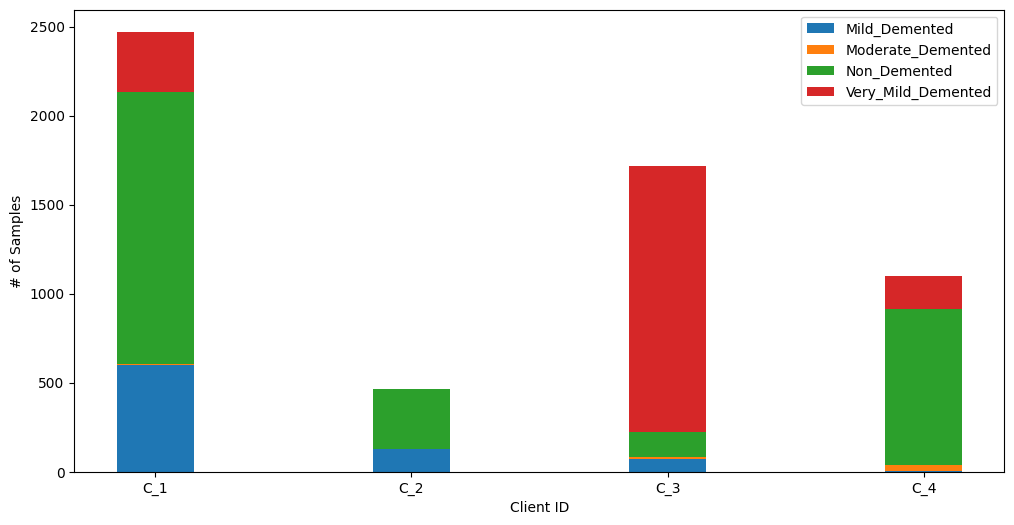

In [19]:
fl_simulator.plotDataDistribution()

In [20]:
central_server = server(test_set, fl_simulator.clients, args)

In [21]:
central_server.test()


Test set: Average loss: 1.3991, Accuracy: 92/640 (14.38%)



(1.3991168901324271, 14.375)

In [22]:
accuracies, losses = central_server.federated_train(10)

communication round: 0
LOCAL_EPOCH: 0  Client: VW_0 	Loss: 1.004656 Accuracy: 2073/3638 (56.982%)
LOCAL_EPOCH: 1  Client: VW_0 	Loss: 0.806577 Accuracy: 2333/3638 (64.129%)
LOCAL_EPOCH: 2  Client: VW_0 	Loss: 0.709508 Accuracy: 2531/3638 (69.571%)
LOCAL_EPOCH: 3  Client: VW_0 	Loss: 0.619959 Accuracy: 2760/3638 (75.866%)
LOCAL_EPOCH: 4  Client: VW_0 	Loss: 0.534551 Accuracy: 2954/3638 (81.198%)
LOCAL_EPOCH: 5  Client: VW_0 	Loss: 0.453282 Accuracy: 3109/3638 (85.459%)
LOCAL_EPOCH: 6  Client: VW_0 	Loss: 0.379916 Accuracy: 3215/3638 (88.373%)
LOCAL_EPOCH: 7  Client: VW_0 	Loss: 0.305498 Accuracy: 3352/3638 (92.139%)
LOCAL_EPOCH: 8  Client: VW_0 	Loss: 0.252410 Accuracy: 3417/3638 (93.925%)
LOCAL_EPOCH: 9  Client: VW_0 	Loss: 0.199258 Accuracy: 3467/3638 (95.300%)
LOCAL_EPOCH: 10  Client: VW_0 	Loss: 0.167576 Accuracy: 3519/3638 (96.729%)
LOCAL_EPOCH: 11  Client: VW_0 	Loss: 0.136852 Accuracy: 3530/3638 (97.031%)
LOCAL_EPOCH: 12  Client: VW_0 	Loss: 0.111295 Accuracy: 3556/3638 (97.746%)

/tmp/ipykernel_34/3954499948.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aggregatedUpdates[layer] = torch.tensor(aggregatedUpdates[layer] / totalSample)



Test set: Average loss: 0.7650, Accuracy: 461/640 (72.03%)

communication round: 1
LOCAL_EPOCH: 0  Client: VW_3 	Loss: 0.697108 Accuracy: 1878/2494 (75.301%)
LOCAL_EPOCH: 1  Client: VW_3 	Loss: 0.467632 Accuracy: 2054/2494 (82.358%)
LOCAL_EPOCH: 2  Client: VW_3 	Loss: 0.373707 Accuracy: 2144/2494 (85.966%)
LOCAL_EPOCH: 3  Client: VW_3 	Loss: 0.312037 Accuracy: 2206/2494 (88.452%)
LOCAL_EPOCH: 4  Client: VW_3 	Loss: 0.244054 Accuracy: 2280/2494 (91.419%)
LOCAL_EPOCH: 5  Client: VW_3 	Loss: 0.218778 Accuracy: 2303/2494 (92.342%)
LOCAL_EPOCH: 6  Client: VW_3 	Loss: 0.176821 Accuracy: 2346/2494 (94.066%)
LOCAL_EPOCH: 7  Client: VW_3 	Loss: 0.143369 Accuracy: 2379/2494 (95.389%)
LOCAL_EPOCH: 8  Client: VW_3 	Loss: 0.123091 Accuracy: 2402/2494 (96.311%)
LOCAL_EPOCH: 9  Client: VW_3 	Loss: 0.106362 Accuracy: 2418/2494 (96.953%)
LOCAL_EPOCH: 10  Client: VW_3 	Loss: 0.085277 Accuracy: 2443/2494 (97.955%)
LOCAL_EPOCH: 11  Client: VW_3 	Loss: 0.069855 Accuracy: 2452/2494 (98.316%)
LOCAL_EPOCH: 1

In [23]:
central_server.test()


Test set: Average loss: 1.7790, Accuracy: 475/640 (74.22%)



(1.7789823784804326, 74.21875)

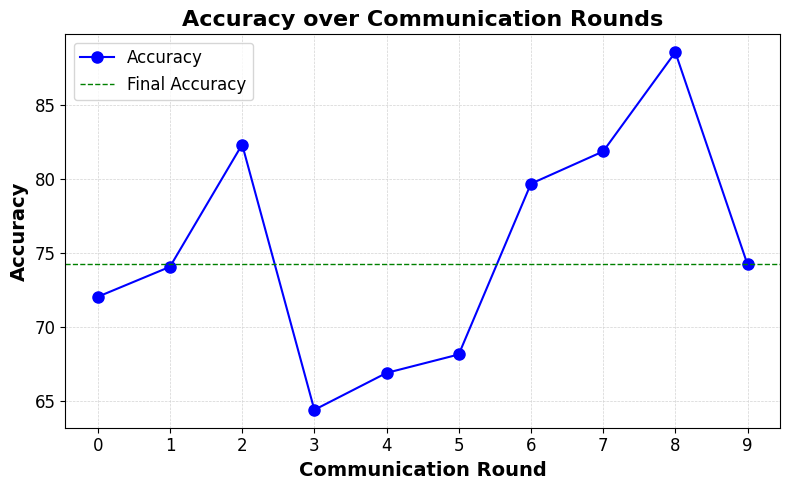

In [24]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(len(accuracies)), accuracies, marker='o', markersize=8, linestyle='-', color='blue', label='Accuracy')  # Customize marker, size, line style, and color
plt.xticks(range(len(accuracies)), fontsize=12) 
plt.yticks(fontsize=12)  
plt.xlabel('Communication Round', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Accuracy over Communication Rounds', fontsize=16, fontweight='bold')

plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.axhline(y=accuracies[-1], color='green', linestyle='--', linewidth=1, label='Final Accuracy')  # Add a line for final accuracy
plt.legend(fontsize=12, loc='upper left')  # Adjust legend position
plt.tight_layout()
plt.savefig('iid-3-90.png')
plt.show()